In [54]:
import xarray as xr
import numpy as np
import scipy.stats as stats

from scores.probability import crps_for_ensemble, tail_twcrps_for_ensemble

np.random.seed(100)

In [51]:
X_LEN = 100
Y_LEN = 100

# Convection

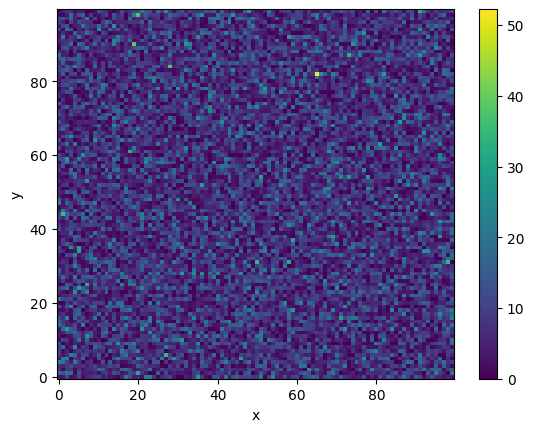

In [91]:
# Generate random values from a skew normal distribution
obs_convection = stats.skewnorm.rvs(a=10, scale=10, size=(Y_LEN, X_LEN)).clip(min=0)
obs_convection = xr.DataArray(
    obs_convection,
    dims=("y", "x"),
    coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)},
)

fcst_convection = stats.skewnorm.rvs(a=10, scale=10, size=(Y_LEN, X_LEN)).clip(min=0)
fcst_convection = xr.DataArray(
    fcst_convection,
    dims=("y", "x"),
    coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)},
)

fcst_clim = data = np.full((Y_LEN, X_LEN), obs_convection.mean().values)
fcst_clim = xr.DataArray(
    fcst_clim, dims=("y", "x"), coords={"x": np.arange(X_LEN), "y": np.arange(Y_LEN)}
)

obs_convection.plot()

In [88]:
def create_neighourhood_ensemble(fcst, neighborhood, remove_incomplete_ens=True):
    ensemble = fcst.rolling(
        dim=dict(x=neighborhood, y=neighborhood), center=True
    ).construct(x="i", y="j")
    ensemble = ensemble.stack(ens_mem=("i", "j"))
    if remove_incomplete_ens:
        ensemble = ensemble.where(~np.isnan(ensemble).any(dim="ens_mem"), np.nan)
    # Clean up coordinates for crps calculation
    ensemble = ensemble.drop_vars("ens_mem")
    ensemble = ensemble.assign_coords(ens_mem=np.arange(neighborhood**2))
    return ensemble


NEIGHBORHOOD = 5

fcst_conv_ens = create_neighourhood_ensemble(fcst_convection, NEIGHBORHOOD)
fcst_clim_ens = create_neighourhood_ensemble(fcst_clim, NEIGHBORHOOD)

In [89]:
crps_for_ensemble(fcst_conv_ens, obs_convection, ensemble_member_dim="ens_mem")

<xarray.DataArray ()>
array(3.41675717)

In [90]:
crps_for_ensemble(fcst_clim_ens, obs_convection, ensemble_member_dim="ens_mem")

<xarray.DataArray ()>
array(4.77382118)